# Example: ML adjusted calibrator

## Covid-19 example

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
from random import sample
import scipy.stats as sps
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
current = os.path.abspath(os.getcwd())
sys.path.append(os.path.normpath(os.path.join(os.path.dirname(current), '..')))
from base.calibration import calibrator 
from base.emulation import emulator

In [4]:
# Read data 
real_data = np.loadtxt('real_observations.csv', delimiter=',')
description = np.loadtxt('observation_description.csv', delimiter=',',dtype='object')
param_values = 1/np.loadtxt('param_values.csv', delimiter=',')
func_eval = np.loadtxt('func_eval.csv', delimiter=',')
param_values_test = 1/np.loadtxt('param_values_test.csv', delimiter=',')
func_eval_test = np.loadtxt('func_eval_test.csv', delimiter=',')

# Remove the initial 30-days time period from the data
keepinds = np.squeeze(np.where(description[:,0].astype('float') > 30))
real_data = real_data[keepinds]
description = description[keepinds, :]
func_eval = func_eval[:,keepinds]
func_eval_test = func_eval_test[:, keepinds]

print('N:', func_eval.shape[0])
print('D:', param_values.shape[1])
print('M:', real_data.shape[0])
print('P:', description.shape[1])

# Get the random sample of 500 out of 2000
rndsample = sample(range(0, 2000), 500)
func_eval_rnd = func_eval[rndsample, :]
param_values_rnd = param_values[rndsample, :]

def plot_model_data(description, func_eval, real_data, param_values, title = None):
    '''
    Plots a list of profiles in the same figure. Each profile corresponds
    to a simulation replica for the given instance.
    '''
    plt.rcParams["font.size"] = "10"
    N = len(param_values)
    D = description.shape[1]
    T = len(np.unique(description[:,0]))
    type_no = len(np.unique(description[:,1]))
    fig, axs = plt.subplots(type_no, figsize=(8, 12))

    for j in range(type_no):
        for i in range(N):
            p2 = axs[j].plot(range(T), func_eval[i,(j*T):(j*T + T)], color='grey', alpha = 0.25)
        p1 = axs[j].plot(range(T), real_data[(j*T):(j*T + T)], 'ro', markersize = 5, color='red')
        if j == 0:
            axs[j].set_ylabel('COVID-19 Total Hospitalizations')
        elif j == 1:
            axs[j].set_ylabel('COVID-19 Hospital Admissions')
        elif j == 2:
            axs[j].set_ylabel('COVID-19 ICU Patients')
        axs[j].set_xlabel('Time (days)')
        axs[j].legend([p1[0], p2[0]], ['observations', 'computer model'])
    plt.show()

N: 2000
D: 10
M: 402
P: 2


### Filtering data

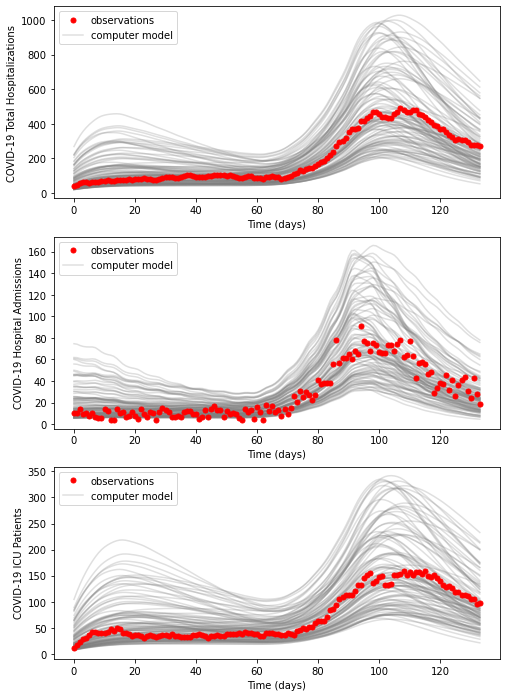

In [5]:
# Filter out the data
par_out = param_values_rnd[np.logical_or.reduce((func_eval_rnd[:, 100] <= 200, func_eval_rnd[:, 20] >= 1000, func_eval_rnd[:, 100] >= 1000)),:]
par_in = param_values_rnd[np.logical_and.reduce((func_eval_rnd[:, 100] > 200, func_eval_rnd[:, 20] < 1000, func_eval_rnd[:, 100] < 1000)), :]
func_eval_in = func_eval_rnd[np.logical_and.reduce((func_eval_rnd[:, 100] > 200, func_eval_rnd[:, 20] < 1000, func_eval_rnd[:, 100] < 1000)), :]
par_in_test = param_values_test[np.logical_and.reduce((func_eval_test[:, 100] > 200, func_eval_test[:, 20] < 1000, func_eval_test[:, 100] < 1000)), :]
func_eval_in_test = func_eval_test[np.logical_and.reduce((func_eval_test[:, 100] > 200, func_eval_test[:, 20] < 1000, func_eval_test[:, 100] < 1000)), :]

# (Filter) Observe computer model outputs     
plot_model_data(description, func_eval_in, real_data, par_in, title='Computer model output')

### Model emulation via filtered data

In [6]:
x = np.hstack((np.reshape(np.tile(range(134), 3), (402, 1)),
              np.reshape(np.tile(np.array(('tothosp','totadmiss','icu')),134), (402, 1))))
x =  np.array(x, dtype='object')

# (No filter) Fit an emulator via 'PCGPwM'
emulator_1 = emulator(x = x, theta = param_values_rnd, f = func_eval_rnd.T, method = 'PCGPwM') 

# (Filter) Fit an emulator via 'PCGPwM'
emulator_f_1 = emulator(x = x, theta = par_in, f = func_eval_in.T, method = 'PCGPwM') 

10
6


### Fitting a classifier

In [7]:
# Run a classification model
pred_1 = emulator_1.predict(x, param_values_rnd)
pred_mean_1 = pred_1.mean()
y = np.zeros(len(pred_mean_1.T))
y[np.logical_and.reduce((pred_mean_1.T[:, 100] > 200, pred_mean_1.T[:, 20] < 1000, pred_mean_1.T[:, 100] < 1000))] = 1
 
# Create the test data
pred_1_test = emulator_1.predict(x, param_values_test)
pred_mean_1_test = pred_1_test.mean()
y_test = np.zeros(len(pred_mean_1_test.T))
y_test[np.logical_and.reduce((pred_mean_1_test.T[:, 100] > 200, pred_mean_1_test.T[:, 20] < 1000, pred_mean_1_test.T[:, 100] < 1000))] = 1

# Create a balanced data set
X_0 = param_values_rnd[y == 0][0:130]
y_0 = y[y == 0][0:130]
X_1 = param_values_rnd[y == 1]
y_1 = y[y == 1]
    
X = np.concatenate((X_0, X_1), axis=0)
y = np.concatenate((y_0, y_1), axis=0)

# Fit the classification model
model = RandomForestClassifier(n_estimators = 100, random_state = 42)
model.fit(X, y)

#Training accuracy
print(model.score(X, y))
print(confusion_matrix(y, model.predict(X)))

#Test accuracy
print(model.score(param_values_test, y_test))
print(confusion_matrix(y_test, model.predict(param_values_test)))

1.0
[[130   0]
 [  0 105]]
0.708
[[1173  383]
 [ 201  243]]


### Model calibration via ML

In [8]:
# Define a class for prior of 10 parameters
class prior_covid:
    """ This defines the class instance of priors provided to the method. """
    def lpdf(theta):
        if theta.ndim > 1.5:
            return np.squeeze(sps.norm.logpdf(theta[:, 0], 2.5, 0.5) + 
                              sps.norm.logpdf(theta[:, 1], 4.0, 0.5) + 
                              sps.norm.logpdf(theta[:, 2], 4.0, 0.5) + 
                              sps.norm.logpdf(theta[:, 3], 1.875, 0.1) + 
                              sps.norm.logpdf(theta[:, 4], 14, 1.5) + 
                              sps.norm.logpdf(theta[:, 5], 18, 1.5) + 
                              sps.norm.logpdf(theta[:, 6], 20, 1.5) + 
                              sps.norm.logpdf(theta[:, 7], 14, 1.5) + 
                              sps.norm.logpdf(theta[:, 8], 13, 1.5) + 
                              sps.norm.logpdf(theta[:, 9], 12, 1.5))
        else:
            return np.squeeze(sps.norm.logpdf(theta[0], 2.5, 0.5) + 
                              sps.norm.logpdf(theta[1], 4.0, 0.5) + 
                              sps.norm.logpdf(theta[2], 4.0, 0.5) + 
                              sps.norm.logpdf(theta[3], 1.875, 0.1) + 
                              sps.norm.logpdf(theta[4], 14, 1.5) + 
                              sps.norm.logpdf(theta[5], 18, 1.5) + 
                              sps.norm.logpdf(theta[6], 20, 1.5) + 
                              sps.norm.logpdf(theta[7], 14, 1.5) + 
                              sps.norm.logpdf(theta[8], 13, 1.5) + 
                              sps.norm.logpdf(theta[9], 12, 1.5))
            

    def rnd(n):
        return np.vstack((sps.norm.rvs(2.5, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(4.0, 0.5, size=n),
                          sps.norm.rvs(1.875, 0.1, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(18, 1.5, size=n),
                          sps.norm.rvs(20, 1.5, size=n),
                          sps.norm.rvs(14, 1.5, size=n),
                          sps.norm.rvs(13, 1.5, size=n),
                          sps.norm.rvs(12, 1.5, size=n))).T
    
def boxplot_param(theta):
    plt.rcParams["font.size"] = "16"
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    paraind = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].boxplot(theta[:, paraind])
            paraind += 1

    fig.tight_layout()
    fig.subplots_adjust(bottom=0.05, top=0.95)
    plt.show()

def plot_pred_interval(cal):
    pr = cal.predict(x)
    rndm_m = pr.rnd(s = 100)
    plt.rcParams["font.size"] = "10"
    fig, axs = plt.subplots(3, figsize=(8, 12))

    for j in range(3):
        upper = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 97.5, axis = 0)
        lower = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 2.5, axis = 0)
        median = np.percentile(rndm_m[:, j*134 : (j + 1)*134], 50, axis = 0)
        p1 = axs[j].plot(median, color = 'black')
        axs[j].fill_between(range(0, 134), lower, upper, color = 'grey')
        p3 = axs[j].plot(range(0, 134), real_data[j*134 : (j + 1)*134], 'ro' ,markersize = 5, color='red')
        if j == 0:
            axs[j].set_ylabel('COVID-19 Total Hospitalizations')
        elif j == 1:
            axs[j].set_ylabel('COVID-19 Hospital Admissions')
        elif j == 2:
            axs[j].set_ylabel('COVID-19 ICU Patients')
        axs[j].set_xlabel('Time (days)')  
    
        axs[j].legend([p1[0], p3[0]], ['prediction','observations'])
    fig.tight_layout()
    fig.subplots_adjust(top=0.9) 
    plt.show()
    
obsvar = np.maximum(0.2*real_data, 5) 

n_acc rate= 0.769


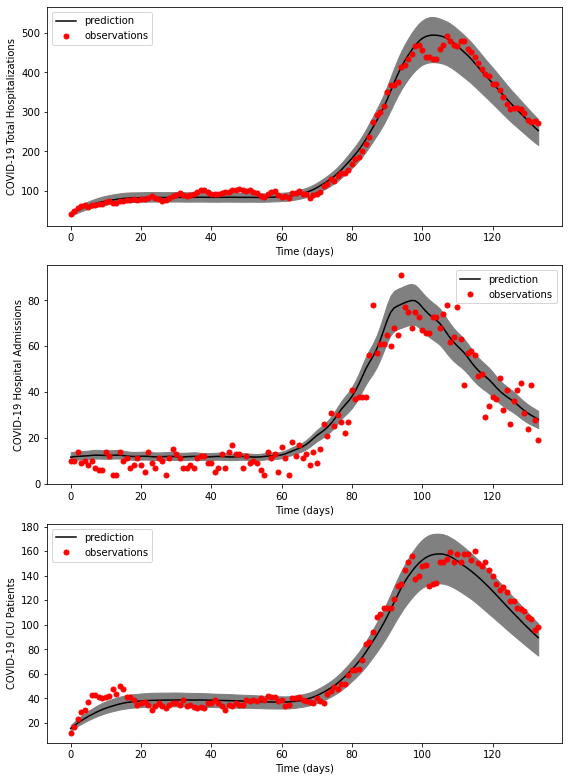

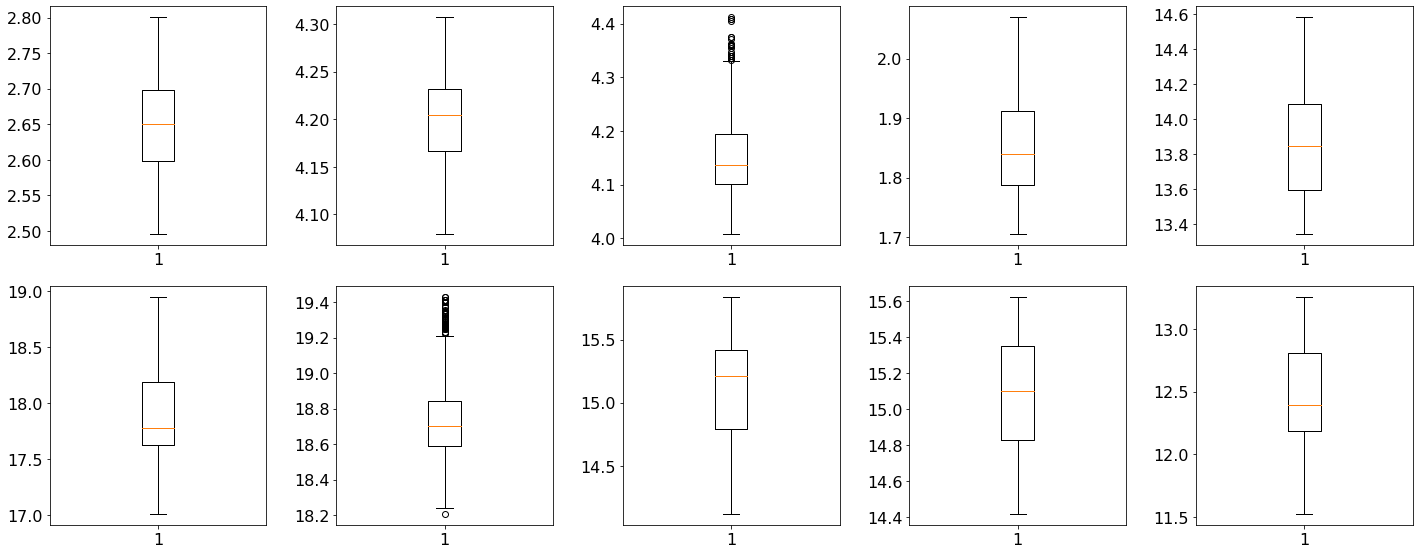

In [9]:
cal_f_1 = calibrator(emu = emulator_f_1, y = real_data, x = x, thetaprior = prior_covid, method = 'MLcal', yvar = obsvar, 
                        args = {'theta0': np.array([2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]), 
                                'numsamp' : 1000, 
                                'stepType' : 'normal', 
                                'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

plot_pred_interval(cal_f_1)
cal_f_1_theta = cal_f_1.theta.rnd(1000) 
boxplot_param(cal_f_1_theta)

In [ ]:
cal_f_ml_1 = calibrator(emu = emulator_f_1, y = real_data, x = x, thetaprior = prior_covid, method = 'MLcal', yvar = obsvar, 
                        args = {'clf_method': model, 
                                'theta0': np.array([2, 4, 4, 1.875, 14, 18, 20, 14, 13, 12]), 
                                'numsamp' : 1000, 
                                'stepType' : 'normal', 
                                'stepParam' : np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03])})

plot_pred_interval(cal_f_ml_1)
cal_f_ml_1_theta = cal_f_ml_1.theta.rnd(1000) 
boxplot_param(cal_f_ml_1_theta)